In [1]:
import sympy as sym
import numpy as np
from scipy import integrate

import math

from sympy.functions import Heaviside, sin, cos, sqrt
sym.init_printing()

import matplotlib.pyplot as plt
#from sympy.vector import *
from sympy import I, Matrix, symbols
from sympy.physics.quantum import TensorProduct,Dagger

# This IPython magic generates a table with version information
#https://github.com/jrjohansson/version_information
#%load_ext version_information


In [2]:


def spre(m):
    return TensorProduct(sym.eye(m.shape[0]),m)


def spost(m):
    return TensorProduct(m.T,sym.eye(m.shape[0]))

def collapse(c):
    temp = Dagger(c)*c
    return 2*spre(c)*spost(Dagger(c))-spre(temp)-spost(temp)


s13=Matrix([[0,0,1],[0,0,0],[0,0,0]])
s23=Matrix([[0,0,0],[0,0,1],[0,0,0]])
s12=Matrix([[0,1,0],[0,0,0],[0,0,0]])

s31=s13.T
s32=s23.T
s21=s12.T

s11 = s12*s21
s22 = s21*s12
s33 = s31*s13



In [37]:
sigmay = Matrix([[0, I], [-I, 0 ]])
sigmay

⎡0   ⅈ⎤
⎢     ⎥
⎣-ⅈ  0⎦

In [38]:
spre(sigmay)

⎡0   ⅈ  0   0⎤
⎢            ⎥
⎢-ⅈ  0  0   0⎥
⎢            ⎥
⎢0   0  0   ⅈ⎥
⎢            ⎥
⎣0   0  -ⅈ  0⎦

In [39]:
spost(sigmay)

⎡0  0  -ⅈ  0 ⎤
⎢            ⎥
⎢0  0  0   -ⅈ⎥
⎢            ⎥
⎢ⅈ  0  0   0 ⎥
⎢            ⎥
⎣0  ⅈ  0   0 ⎦

In [3]:
delta2,delta3 = sym.symbols('delta_2 delta_3',real=True)
gamma13,gamma23,gamma2d,gamma3d,nbath,gammamu = sym.symbols('gamma_13 gamma_23 gamma_2d gamma_3d n_b gamma_mu', real=True, negative=False)
omegao,omegam,a = sym.symbols('Omega_o Omega_mu a')
g = sym.symbols('g',real=True, negative=False)
sigmm,sigmo = sym.symbols('sigma_m sigma_o')

In [4]:
H =  omegam*s21 + omegao*s32 + g*a*s31
H = H + Dagger(H)
H = H + delta2*s22 + delta3*s33
LH = -I*spre(H)+I*spost(H) 
L21 = gammamu/2*(nbath+1)*collapse(s12)
L12 = gammamu/2*(nbath)*collapse(s21)
L32 = gamma23/2*collapse(s23)
L31 = gamma13/2*collapse(s13)
L22 = gamma2d/2*collapse(s22)
L33 = gamma3d/2*collapse(s33)

L = LH + L21 + L12 + L32 + L31 + L22 + L33

#becausetrace rho = 1 we can replace first row
L = L.row_insert(0,Matrix([[1,0,0,0,1,0,0,0,1]]))
L.row_del(1)


L

⎡   1                       0                                     0           
⎢                                                                             
⎢                 γ_2d   γₘᵤ⋅n_b   γₘᵤ⋅(n_b + 1)                   __         
⎢-ⅈ⋅Ωₘᵤ   -ⅈ⋅δ₂ - ──── - ─────── - ─────────────                -ⅈ⋅Ωₒ         
⎢                  2        2            2                                    
⎢                                                                             
⎢                                                         γ₁₃   γ₂₃   γ_3d   γ
⎢-ⅈ⋅a⋅g                   -ⅈ⋅Ωₒ                   -ⅈ⋅δ₃ - ─── - ─── - ──── - ─
⎢                                                          2     2     2      
⎢                                                                             
⎢   ___                                                                       
⎢ ⅈ⋅Ωₘᵤ                     0                                     0           
⎢                                                   

In [5]:
#L[:,0:3] #because the matrix gets clipped

In [6]:
#L[:,3:6]

In [7]:
#L[:,6:]

In [8]:
#rho11,rho12,rho13,rho21,rho22,rho23,rho31,rho32,rho33 = sym.symbols('rho_11 rho_12 rho_13 rho_21 rho_22 rho_23 rho_31 rho_32 rho_33')
#rho = Matrix([[rho11,rho21,rho31],[rho12,rho22,rho32],[rho13,rho23,rho33]])
#rho = 1*rho.T
#rho[:]
#rhoflat = 1*rho.T 
#rhoflat = rhoflat[:]
#rhoflat[6]

In [9]:
from sympy.printing import print_ccode
Lflat = 1*L.T
Lflat = Lflat[:]
print_ccode(Lflat)

// Not supported in C:
// conjugate
// conjugate
// conjugate
[1, -I*Omega_mu, -I*a*g, I*conjugate(Omega_mu), gamma_mu*n_b, 0, I*g*conjugate(a), 0, 0, 0, -I*delta_2 - 1.0/2.0*gamma_2d - 1.0/2.0*gamma_mu*n_b - 1.0/2.0*gamma_mu*(n_b + 1), -I*Omega_o, 0, I*conjugate(Omega_mu), 0, 0, I*g*conjugate(a), 0, 0, -I*conjugate(Omega_o), -I*delta_3 - 1.0/2.0*gamma_13 - 1.0/2.0*gamma_23 - 1.0/2.0*gamma_3d - 1.0/2.0*gamma_mu*n_b, 0, 0, I*conjugate(Omega_mu), 0, 0, I*g*conjugate(a), 0, 0, 0, I*delta_2 - 1.0/2.0*gamma_2d - 1.0/2.0*gamma_mu*n_b - 1.0/2.0*gamma_mu*(n_b + 1), -I*Omega_mu, -I*a*g, I*conjugate(Omega_o), 0, 0, 1, I*Omega_mu, 0, -I*conjugate(Omega_mu), -gamma_mu*(n_b + 1), -I*Omega_o, 0, I*conjugate(Omega_o), 0, 0, 0, I*Omega_mu, -I*g*conjugate(a), -I*conjugate(Omega_o), I*delta_2 - I*delta_3 - 1.0/2.0*gamma_13 - 1.0/2.0*gamma_23 - 1.0/2.0*gamma_2d - 1.0/2.0*gamma_3d - 1.0/2.0*gamma_mu*(n_b + 1), 0, 0, I*conjugate(Omega_o), 0, 0, 0, I*Omega_o, 0, 0, I*delta_3 - 1.0/2.0*gamma_13 - 1.0/2.0*gam

## Turning analytic expression into numerical code to work out steady state

In [32]:
Lfunc = sym.lambdify((a,delta2, delta3, gamma13, gamma23, gamma2d, gamma3d, nbath,gammamu,omegao,omegam,g),L)
        
        
#    return 
#delta2,delta3 = sym.symbols('delta_2 delta_3',real=True)
#gamma13,gamma23,gamma2d,gamma3d,nbath,gammamu = sym.symbols('gamma_13 gamma_23 gamma_2d gamma_3d n_b gamma_mu', real=True, negative=False)
#omegao,omegam,a = sym.symbols('Omega_o Omega_mu a')
#g = sym.symbols('g',real=True, negative=False)

def steady_rho(p):
    
    Lmatrix = Lfunc(p['a'],p['delta2'],p['delta3'],p['gamma13'],
                               p['gamma23'],p['gamma2d'],p['gamma3d'],p['nbath'],
                               p['gammamu'],p['omegao'],p['omegam'],p['g'])
    
    #return Lmatrix
    rho = np.linalg.solve(Lmatrix.astype('complex128'),np.matrix([[1,0,0,0,0,0,0,0,0]]).T)
    return np.reshape(rho,(3,3),order='F')

def steady_rho13(p):
    
    Lmatrix = Lfunc(p['a'],p['delta2'],p['delta3'],p['gamma13'],
                               p['gamma23'],p['gamma2d'],p['gamma3d'],p['nbath'],
                               p['gammamu'],p['omegao'],p['omegam'],p['g'])
    
    #return Lmatrix
    rho = np.linalg.solve(Lmatrix.astype('complex128'),np.matrix([[1,0,0,0,0,0,0,0,0]]).T)
    return rho[6]


def steady_rho_for_integration(delta2,delta3,p):
    params = p
    params['delta2'] = delta2
    params['delta3'] = delta3
    m2=params['mean_delta2']
    sd2=params['sd_delta2']
    m3=params['mean_delta3']
    sd3=params['sd_delta3']
    return 1/(2*np.pi*sd3*sd2) * np.exp(-(delta2-m2)**2/(2*sd2*sd2)-(delta3-m3)**2/(2*sd3*sd3)) * steady_rho13(params)


def integrate_over_delta2(delta3,p):
    a = p['mean_delta2']-4*p['sd_delta2']
    b = p['mean_delta2']+4*p['sd_delta2']
    # points = 
    output = integrate.quad(steady_rho_for_integration, a, b, args=(delta3,p))
    return output[0]
    

# scipy.integrate.quad(func, a, b, args=(), full_output=0, epsabs=1.49e-08, epsrel=1.49e-08, limit=50, points=None, weight=None, wvar=None, wopts=None, maxp1=50, limlst=50)[source]
def ensemble_steady_rho(p):
    a = p['mean_delta3']-4*p['sd_delta3']
    b = p['mean_delta3']+4*p['sd_delta3']
    # output = integrate.quad(integrate_over_delta2,a,b,args=p, epsabs=1.49e-07, epsrel=1.49e-07)
    delta
    return output[0]
    
#integrate steady_rho over distribution defined by
#p['mean_delta2']
#p['sd_delta2']
#p['mean_delta3']
#p['mean_delta4']


#def steady_rho13(p):
#    return steady_rho[0,2]

# Example single pass like calculations no inhomo

### weird behavior
Signal persists at very high microwave detuning? Is this real?

In [25]:
#some default parameters
p = {}
p['a'] = 0
p['delta2'] = 0.
p['delta3'] = 0.
p['gamma13'] = 1./22e-3
p['gamma23'] = 1./22e-3
p['gamma2d'] = 1./1e-6
p['gamma3d'] = 1./1e-6
p['nbath'] = 20
p['gammamu'] = 1./((p['nbath']+1)*11e-3)
p['omegao'] = 10e6
p['omegam'] = 10e6
p['g'] = 0.

#steady_rho(p)* np.matrix([[1,0,0,0,0,0,0,0,0]]).T
#np.linalg.solve(steady_rho(p),np.matrix([[1,0,0,0,0,0,0,0,0]]).T)
#steady_rho(p)

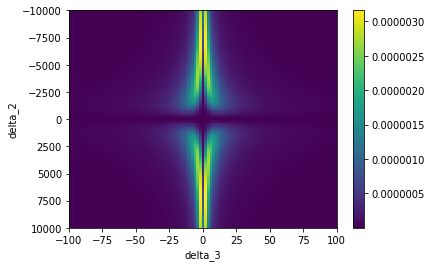

In [26]:
# plt.subplot(1,2,1)

delta2vals = np.linspace(-10000e6,10000e6,101)
delta3vals = np.linspace(-100e6,100e6,101)
coh = np.zeros((len(delta2vals),len(delta3vals)))
for ii in range(len(delta2vals)):
    for jj in range(len(delta3vals)):
        p['delta2']=delta2vals[ii]
        p['delta3']=delta3vals[jj]
        coh[ii,jj] = np.abs(steady_rho(p)[0,2])**2
        
plt.imshow(coh,extent = [min(delta3vals)/1e6,max(delta3vals)/1e6,max(delta2vals)/1e6,min(delta2vals)/1e6],aspect='auto')
plt.ylabel('delta_2')
plt.xlabel('delta_3')
plt.colorbar()
# plt.subplot(1,2,2)

# delta2vals = np.linspace(0,50e6,51)
# delta3vals = np.linspace(0,50e6,51)
# coh = np.zeros((len(delta2vals),len(delta3vals)))
# for ii in range(len(delta2vals)):
#     for jj in range(len(delta3vals)):
#         p['delta2']=delta2vals[ii]
#         p['delta3']=delta3vals[jj]
#         coh[ii,jj] = np.abs(steady_rho(p)[0,2])**2
        
# plt.imshow(coh,extent = [min(delta3vals)/1e6,max(delta3vals)/1e6,max(delta2vals)/1e6,min(delta2vals)/1e6],aspect='auto')
# plt.ylabel('delta_2')
# plt.xlabel('delta_3')
# plt.colorbar()

### more "understandable"  behavior
#### Driving optical pump hard, driving microwaves weakly


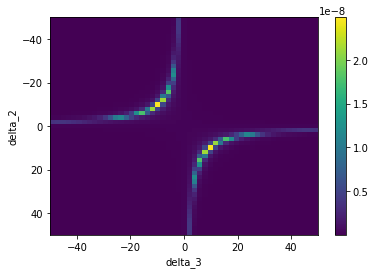

In [27]:
#some default parameters
p = {}
p['a'] = 0
p['delta2'] = 0.
p['delta3'] = 0.
p['gamma13'] = 1./22e-3
p['gamma23'] = 1./22e-3
p['gamma2d'] = 1./1e-6
p['gamma3d'] = 1./1e-6
p['nbath'] = 20
p['gammamu'] = 1./((p['nbath']+1)*11e-3)
p['omegao'] = 10e6
p['omegam'] = 1e3
p['g'] = 0.


delta2vals = np.linspace(-50e6,50e6,51)
delta3vals = np.linspace(-50e6,50e6,51)
coh = np.zeros((len(delta2vals),len(delta3vals)))
for ii in range(len(delta2vals)):
    for jj in range(len(delta3vals)):
        p['delta2']=delta2vals[ii]
        p['delta3']=delta3vals[jj]
        coh[ii,jj] = np.abs(steady_rho(p)[0,2])**2
        
plt.imshow(coh,extent = [min(delta3vals)/1e6,max(delta3vals)/1e6,max(delta2vals)/1e6,min(delta2vals)/1e6],aspect='auto')
plt.ylabel('delta_2')
plt.xlabel('delta_3')
plt.colorbar()

#### Driving optics weakly, microwaves hard

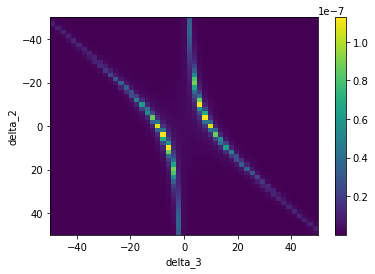

In [28]:
#some default parameters
p = {}
p['a'] = 0
p['delta2'] = 0.
p['delta3'] = 0.
p['gamma13'] = 1./22e-3
p['gamma23'] = 1./22e-3
p['gamma2d'] = 1./1e-6
p['gamma3d'] = 1./1e-6
p['nbath'] = 20
p['gammamu'] = 1./((p['nbath']+1)*11e-3)
p['omegao'] = 1e3
p['omegam'] = 10e6
p['g'] = 0.


delta2vals = np.linspace(-50e6,50e6,51)
delta3vals = np.linspace(-50e6,50e6,51)
coh = np.zeros((len(delta2vals),len(delta3vals)))
for ii in range(len(delta2vals)):
    for jj in range(len(delta3vals)):
        p['delta2']=delta2vals[ii]
        p['delta3']=delta3vals[jj]
        coh[ii,jj] = np.abs(steady_rho(p)[0,2])**2
        
plt.imshow(coh,extent = [min(delta3vals)/1e6,max(delta3vals)/1e6,max(delta2vals)/1e6,min(delta2vals)/1e6],aspect='auto')
plt.ylabel('delta_2')
plt.xlabel('delta_3')
plt.colorbar()

#### driving both weakly

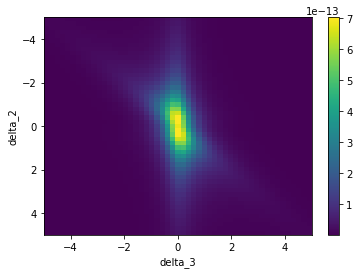

In [29]:
p = {}
p['a'] = 0
p['delta2'] = 0.
p['delta3'] = 0.
p['gamma13'] = 1./22e-3
p['gamma23'] = 1./22e-3
p['gamma2d'] = 1./1e-6
p['gamma3d'] = 1./1e-6
p['nbath'] = 20
p['gammamu'] = 1./((p['nbath']+1)*11e-3)
p['omegao'] = 1e3
p['omegam'] = 1e3
p['g'] = 0.


delta2vals = np.linspace(-5e6,5e6,51)
delta3vals = np.linspace(-5e6,5e6,51)
coh = np.zeros((len(delta2vals),len(delta3vals)))
for ii in range(len(delta2vals)):
    for jj in range(len(delta3vals)):
        p['delta2']=delta2vals[ii]
        p['delta3']=delta3vals[jj]
        coh[ii,jj] = np.abs(steady_rho(p)[0,2])**2
        
plt.imshow(coh,extent = [min(delta3vals)/1e6,max(delta3vals)/1e6,max(delta2vals)/1e6,min(delta2vals)/1e6],aspect='auto')
plt.ylabel('delta_2')
plt.xlabel('delta_3')
plt.colorbar()

### Try out integration over inhomogeneous line

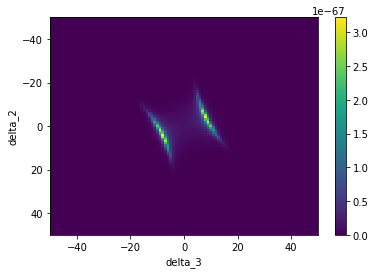

In [33]:
#some default parameters
p = {}
p['a'] = 0
p['delta2'] = 0.
p['delta3'] = 0.
p['gamma13'] = 1./22e-3
p['gamma23'] = 1./22e-3
p['gamma2d'] = 1./1e-6
p['gamma3d'] = 1./1e-6
p['nbath'] = 20
p['gammamu'] = 1./((p['nbath']+1)*11e-3)
p['omegao'] = 1e3
p['omegam'] = 10e6
p['g'] = 0.

p['mean_delta2']=0
p['sd_delta2']=10e6
p['mean_delta3']=0
p['sd_delta3']=10e6


m2=p['mean_delta2']
sd2=p['sd_delta2']
m3=p['mean_delta3']
sd3=p['sd_delta3']

delta2vals = np.linspace(-50e6,50e6,101)
delta3vals = np.linspace(-50e6,50e6,101)
coh = np.zeros((len(delta2vals),len(delta3vals)),dtype='complex128')
for ii in range(len(delta2vals)):
    for jj in range(len(delta3vals)):
        p['delta2']=delta2vals[ii]
        p['delta3']=delta3vals[jj]
        gaussie = 1/(2*np.pi*sd3*sd2) * np.exp(-(p['delta2']-m2)**2/(2*sd2*sd2)-(p['delta3']-m3)**2/(2*sd3*sd3))            
        coh[ii,jj] = steady_rho(p)[0,2]* 1/(2*np.pi*sd3*sd2) *gaussie
        
plt.imshow(np.abs(coh)**2,extent = [min(delta3vals)/1e6,max(delta3vals)/1e6,max(delta2vals)/1e6,min(delta2vals)/1e6],aspect='auto')
plt.ylabel('delta_2')
plt.xlabel('delta_3')
plt.colorbar()

In [35]:
ensemble_steady_rho(p)



TypeError: can't convert complex to float

In [ ]:
from scipy import integrate

integrate.quad
